# #############################


# SECTION: Library Installations and GPU checks

In [1]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU (Metal) is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 1


# SECTION: Imports and more Libary Installs

In [2]:
# ! pip install tensorflow-datasets

In [3]:
# ! pip install openpyxl

In [4]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# shap
#import shap

import openpyxl

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


random.seed(42)
%matplotlib inline

# FILL IN CODE HERE #
RANDOM_SAMPLES_VAL = 100000 #To make computing on local machine, colab palatable, we will use a random sample for the exercise  

# SECTION: Our helper and utility functions

In [5]:
#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

# SECTION: Data Load

In [6]:
! pwd

/Users/vishalsaxena/Documents/BERKMIDS2024ROOT/09MIDSCourses/MIDS 207 Applied Machine Learning/207 Final Project/Churn.Models.Phase.2


# Data Load and basic EDA (EDA-Phase-0)
    Objectives:
        1) Load the data set and its data dictionary
        2) Assess shape of loaded data frame, numeric versus non numeric column types
        3) Assess null values
        4) Label class distribution

In [7]:
#Retail Data.csv is our master data file from Kaggle
ecomm_df= pd.read_excel("e_commerce_dataset.xlsx", sheet_name="eComm", engine="openpyxl")


In [8]:
ecomm_df.shape

(5630, 20)

In [9]:
summarize_dataframe(ecomm_df).to_csv('my_ecomm_data_frame.csv')

In [10]:
#Data Dictionary
data_dict_df =  pd.read_excel("e_commerce_dataset.xlsx", sheet_name="dataDict", engine="openpyxl")

In [11]:
columns = ['Variable','Description']
data_dict_df = data_dict_df.iloc[1:,2:4]
data_dict_df.columns = columns


In [12]:
data_dict_df

,Variable,Description
1,CustomerID,Unique customer ID
2,Churn,Churn Flag
3,Tenure,Tenure of customer in organization
4,PreferredLoginDevice,Preferred login device of customer
5,CityTier,City tier
6,WarehouseToHome,Distance in between warehouse to home of customer
7,PreferredPaymentMode,Preferred payment method of customer
8,Gender,Gender of customer
9,HourSpendOnApp,Number of hours spend on mobile application or...
10,NumberOfDeviceRegistered,Total number of deceives is registered on part...


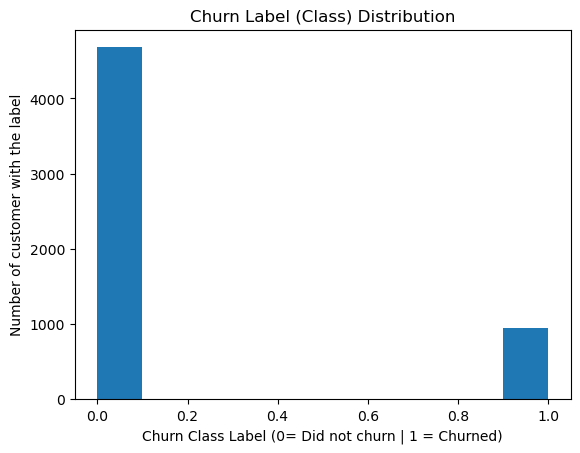

In [13]:
plt.hist(ecomm_df['Churn'])
plt.title('Churn Label (Class) Distribution')
plt.ylabel("Number of customer with the label")
plt.xlabel("Churn Class Label (0= Did not churn | 1 = Churned)")
plt.show()

In [14]:
num_not_churned = np.sum(ecomm_df['Churn'] == 0) 
num_churned = np.sum(ecomm_df['Churn'] == 1)
num_total_customers = num_churned + num_not_churned

print("_"*125)
print("Churned versus not churned customers distribution, Original Data set")
print("_"*125)
print(f" Total number of customers: { num_total_customers}")
print(f" Total number of NOT churned customers: { num_not_churned } , { round((num_not_churned / num_total_customers )*100,2)}% ")
print(f" Total number of churned customers: { num_churned } , { round((num_churned / num_total_customers )*100,2)}% ")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
Churned versus not churned customers distribution, Original Data set
_____________________________________________________________________________________________________________________________
 Total number of customers: 5630
 Total number of NOT churned customers: 4682 , 83.16% 
 Total number of churned customers: 948 , 16.84% 
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


In [15]:
summarize_dataframe(ecomm_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CustomerID,int64,0,5630,5630
1,Churn,int64,0,5630,2
2,Tenure,float64,264,5366,36
3,PreferredLoginDevice,object,0,5630,3
4,CityTier,int64,0,5630,3
5,WarehouseToHome,float64,251,5379,34
6,PreferredPaymentMode,object,0,5630,7
7,Gender,object,0,5630,2
8,HourSpendOnApp,float64,255,5375,6
9,NumberOfDeviceRegistered,int64,0,5630,6


In [16]:
ecomm_df.isna().sum().sum()

1856

In [17]:
summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
2,Tenure,float64,264,5366,36
5,WarehouseToHome,float64,251,5379,34
8,HourSpendOnApp,float64,255,5375,6
15,OrderAmountHikeFromlastYear,float64,265,5365,16
16,CouponUsed,float64,256,5374,17
17,OrderCount,float64,258,5372,16
18,DaySinceLastOrder,float64,307,5323,22


In [18]:
ecomm_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [19]:
ecomm_df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [20]:
ecomm_df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


# Findings Data Load and basic EDA (EDA-Phase-0)
    Objectives:
        1) Load the data set and its data dictionary
        2) Assess shape of loaded data frame, numeric versus non numeric column types
        3) Assess null values
        4) Label class distribution
    Findings:
        Findings:

            Shape of data set: (5,630, 20): 5,520 rows and 20 columns
            All columns are numeric, except 5, which are categorical:
                PreferredLoginDevice, PreferredPaymentMode, Gender, PreferredOrderCat, MaritalStatus

            There are 1856 null values across 7 columns, all of which are numeric.
            Churned-versus-not-churned class distribution is appx. 17%-83%


# EDA-Phase-I
    Objectives: 
        1) Handle missing values in data set
        2) Convert categorical values to numeric
        3) Look at correlation matrix
        4) Reject highly correlated features (e.g. if abs(correlation value)>threshold). Retain only one feature of correlated pair.
        5) Further down select by selecting features that have high abs(correlation) with churn, and using domain understanding


In [21]:
# 1 Handle missing values in data set
summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
2,Tenure,float64,264,5366,36
5,WarehouseToHome,float64,251,5379,34
8,HourSpendOnApp,float64,255,5375,6
15,OrderAmountHikeFromlastYear,float64,265,5365,16
16,CouponUsed,float64,256,5374,17
17,OrderCount,float64,258,5372,16
18,DaySinceLastOrder,float64,307,5323,22


In [22]:
ecomm_df.isnull().any(axis=0).shape[0]

20

In [23]:
# Find rows with missing values
missing_rows = ecomm_df[ecomm_df.isnull().any(axis=1)]
# Count missing values per row
missing_count_per_row = ecomm_df.isnull().sum(axis=1)
total_rows = ecomm_df.shape[0]
print("_"*125)
print("Missing row analysis")
print("_"*125)
print(f" Total number of rows: { total_rows}")
print(f" Total number of rows that have missing values: { missing_rows.shape[0]}")
print(f" Maximum count of missing values per row: { max(missing_count_per_row)}")

_____________________________________________________________________________________________________________________________
Missing row analysis
_____________________________________________________________________________________________________________________________
 Total number of rows: 5630
 Total number of rows that have missing values: 1856
 Maximum count of missing values per row: 1


# Our Basis for misssing value imputation
    Rows can be dropped that have missing values, if their percentage is small. In our case, the total number of rows that are missing values are 1856 (33% of total rows). So we cannot drop, missing value rows as we will lose 33% of our data.

    Can we drop rows that have a lot of missing values? Also no, since maximum count of missing values per row is 1.

    So we look towards missing value imputation, and use the following guidelines. 
        Mean imputation works well when the data is approximately normally distributed, meaning it has a symmetrical distribution without signiﬁcant skew or outliers. 
        Median imputation is useful when the data is skewed or has outliers. In these cases, the median is less afected by extreme values and provides a better central tendency estimate.
    
    So, to decide which imputation to use lets look at the univariate distribution 

<Figure size 640x480 with 0 Axes>

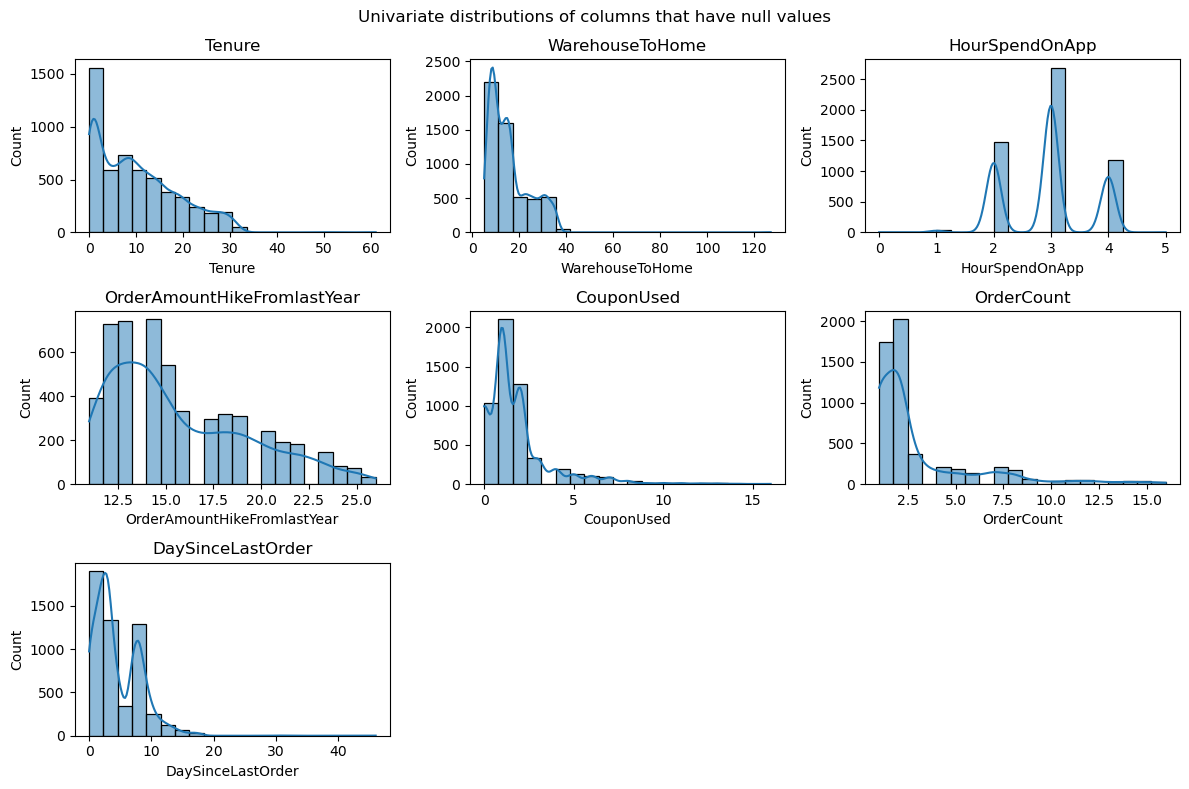

In [24]:
null_df = summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]
null_cols = list(null_df['Column Name'].values)
null_df = ecomm_df[null_cols]
plt.clf()
plt.figure(figsize=(12, 8))
for i, col in enumerate(null_cols, 1):
    plt.subplot(3, 3, i)  # Adjust grid size if needed
    sns.histplot(ecomm_df[col], bins=20, kde=True, edgecolor='black')
    plt.title(col)
plt.suptitle("Univariate distributions of columns that have null values")
plt.tight_layout()
plt.show()

# Comment on plot above
    None of the columns of normal distribution, making mean imputation inappropriate. Plus all of them have outliers. So we will use Median imputation, which is suitabkle for skewed distributions and is more robist to outliers.

In [25]:
null_cols

['Tenure',
 'WarehouseToHome',
 'HourSpendOnApp',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder']

In [26]:
# Median imputation
imputer = SimpleImputer(strategy="median")
ecomm_df[null_cols]=imputer.fit_transform(ecomm_df[null_cols])

In [27]:
summarize_dataframe(ecomm_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CustomerID,int64,0,5630,5630
1,Churn,int64,0,5630,2
2,Tenure,float64,0,5630,36
3,PreferredLoginDevice,object,0,5630,3
4,CityTier,int64,0,5630,3
5,WarehouseToHome,float64,0,5630,34
6,PreferredPaymentMode,object,0,5630,7
7,Gender,object,0,5630,2
8,HourSpendOnApp,float64,0,5630,6
9,NumberOfDeviceRegistered,int64,0,5630,6


#
    As above outout shows, all our null or missing vaulues have been median imputed.
    Now we move to EDA Phase-I Step 2: Convert categorical values to numeric.

In [28]:
# Unique values of categorical colums
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
for col in categorical_cols:
    print(f"Column: {col} | Unique values : { np.unique(ecomm_df[col])} ")

Column: PreferredLoginDevice | Unique values : ['Computer' 'Mobile Phone' 'Phone'] 
Column: PreferredPaymentMode | Unique values : ['CC' 'COD' 'Cash on Delivery' 'Credit Card' 'Debit Card' 'E wallet' 'UPI'] 
Column: Gender | Unique values : ['Female' 'Male'] 
Column: PreferedOrderCat | Unique values : ['Fashion' 'Grocery' 'Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others'] 
Column: MaritalStatus | Unique values : ['Divorced' 'Married' 'Single'] 


In [29]:
continuous_cols = ecomm_df.columns.difference(categorical_cols)
continuous_cols

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome'],
      dtype='object')

In [30]:
#extract continuous columns; extract categorical columns; one hot encode cat columns; get encoded data frame;
# concatenate continuous data frame + encode data frame to get final encoded ecomm_df_encoded 
ecomm_df_cont = ecomm_df[continuous_cols]
ecomm_df_cat = ecomm_df[categorical_cols]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat_array = encoder.fit_transform(ecomm_df_cat)

In [31]:
print(encoded_cat_array[:2])
print(encoder.get_feature_names_out(categorical_cols))
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

[[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.]]
['PreferredLoginDevice_Mobile Phone' 'PreferredLoginDevice_Phone'
 'PreferredPaymentMode_COD' 'PreferredPaymentMode_Cash on Delivery'
 'PreferredPaymentMode_Credit Card' 'PreferredPaymentMode_Debit Card'
 'PreferredPaymentMode_E wallet' 'PreferredPaymentMode_UPI' 'Gender_Male'
 'PreferedOrderCat_Grocery' 'PreferedOrderCat_Laptop & Accessory'
 'PreferedOrderCat_Mobile' 'PreferedOrderCat_Mobile Phone'
 'PreferedOrderCat_Others' 'MaritalStatus_Married' 'MaritalStatus_Single']


In [32]:
encoded_cat_df = pd.DataFrame(encoded_cat_array, columns=encoded_col_names)
encoded_cat_df.head()

,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [33]:
print(f"{ encoded_cat_df.shape = }, { ecomm_df_cont.shape = }, {ecomm_df.shape = }")

 encoded_cat_df.shape = (5630, 16),  ecomm_df_cont.shape = (5630, 15), ecomm_df.shape = (5630, 20)


In [34]:
ecomm_df_encoded = pd.concat([ecomm_df_cont,encoded_cat_df],axis=1)
print(f" { ecomm_df_encoded.shape = }")

  ecomm_df_encoded.shape = (5630, 31)


In [35]:
ecomm_df_encoded.columns

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome',
       'PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

In [36]:
#Standardize column names
def clean_column_names(columns):
    return columns.str.replace(' ', '_').str.replace('&', 'and').str.replace('-', '_')

ecomm_df_encoded.columns = clean_column_names(ecomm_df_encoded.columns)

# Display the updated column names
print(ecomm_df_encoded.columns)

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash_on_Delivery',
       'PreferredPaymentMode_Credit_Card', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_and_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')


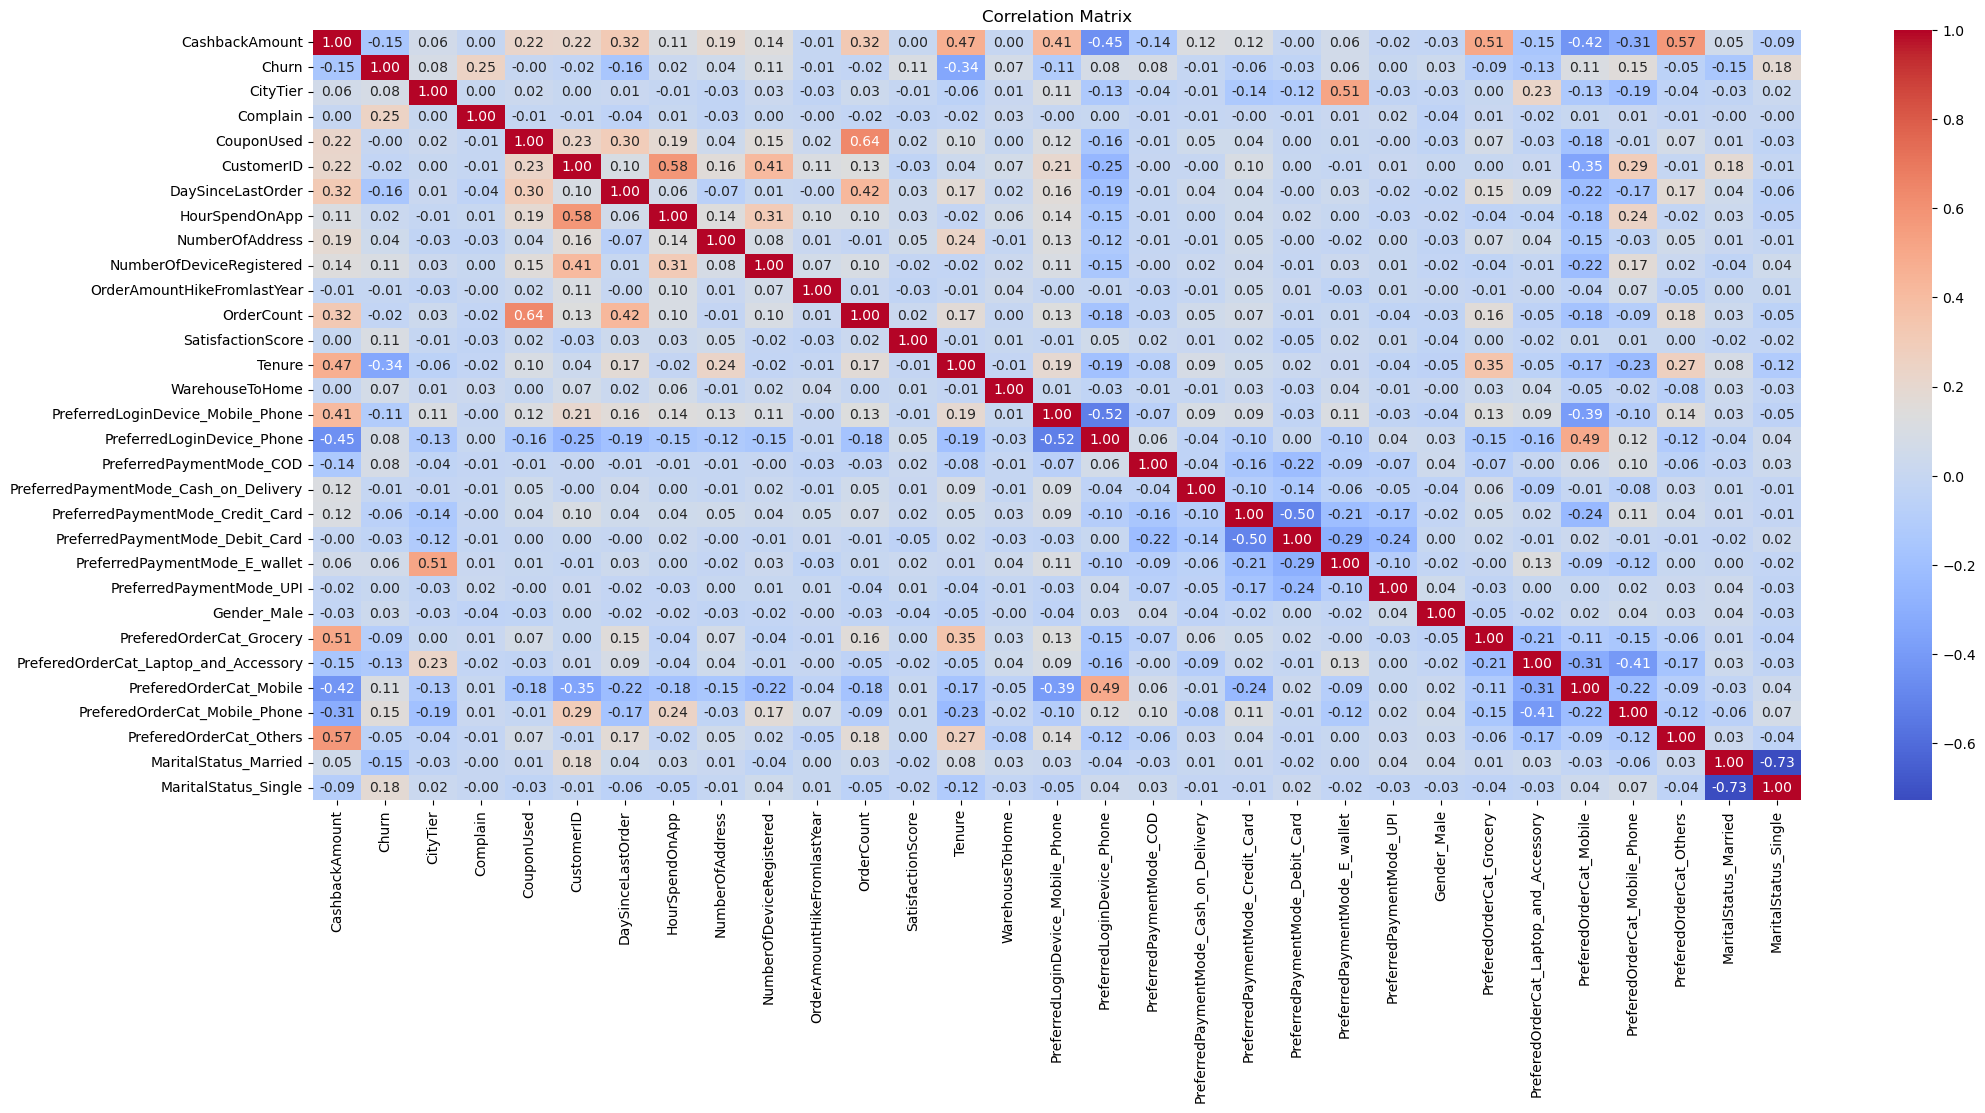

In [37]:
#Visualize correlaion matrix
correlation_matrix = ecomm_df_encoded.corr()
plt.figure(figsize=(24, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Correlation matrix based feature down selection

    4. abs(correlation value) = 0.6 seems to be a good threshold to use to down select from feature pairs that have high correlation value.

    4.1 Marital status married, and single are highly correlated (absolute value = 0.73), but married single has relatively higher abs(correaltion value) with churn (0.18, to 0.15). So from this pair, we will drop MaritalStatus_Married.

    4.2. Similarly, between order count and coupon used, order count makes the cut, and coupon used is dropped. 

In [38]:
drop_col_names = ['MaritalStatus_Married','CouponUsed']

#ecomm_df_encoded_B is ecomm_df_encoded with dropped highly correlated features
ecomm_df_encoded_B = ecomm_df_encoded.drop(columns=drop_col_names)

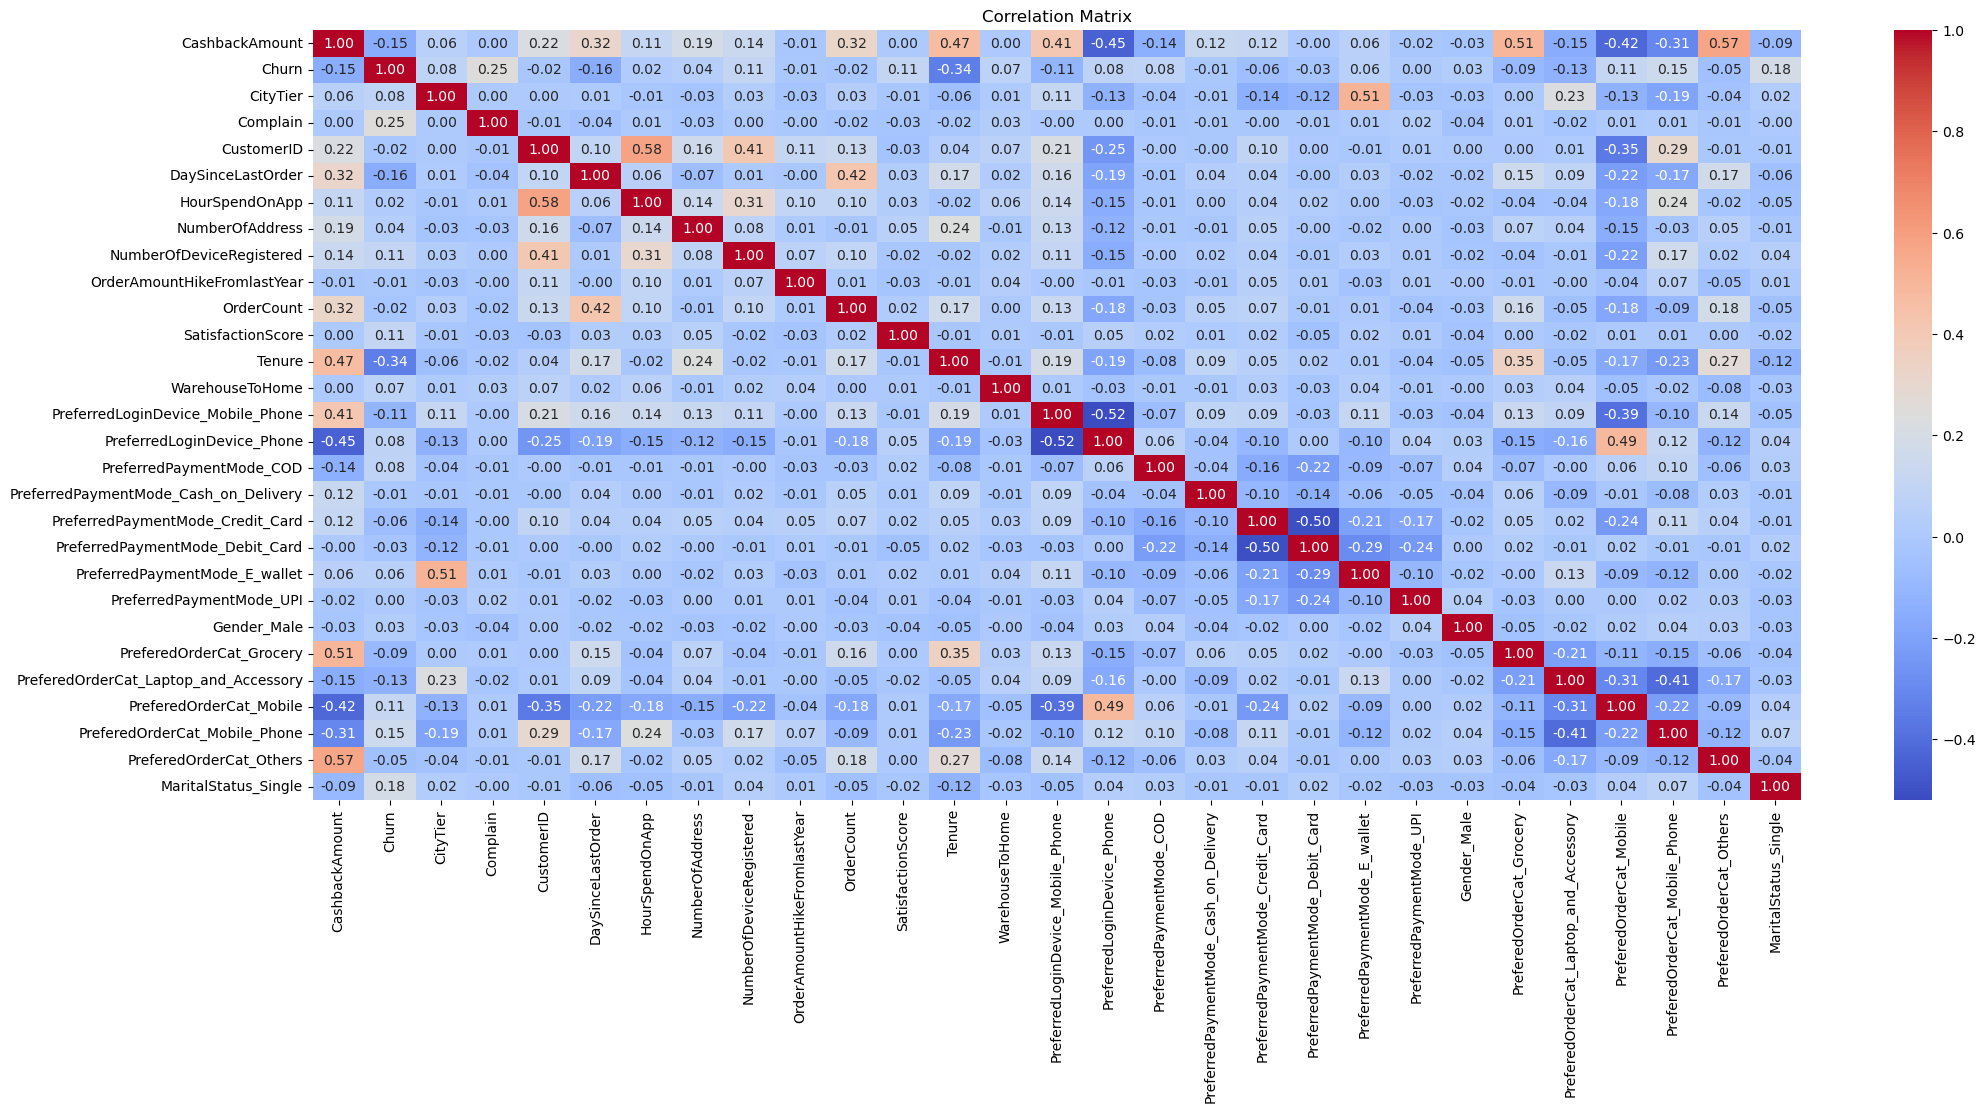

In [39]:
#Visualize correlaion matrix
correlation_matrix = ecomm_df_encoded_B.corr()
plt.figure(figsize=(24, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [40]:
abs(correlation_matrix.loc['Churn']).sort_values()

PreferredPaymentMode_UPI                 0.004163
PreferredPaymentMode_Cash_on_Delivery    0.006178
OrderAmountHikeFromlastYear              0.007075
HourSpendOnApp                           0.018816
CustomerID                               0.019083
OrderCount                               0.024038
Gender_Male                              0.029264
PreferredPaymentMode_Debit_Card          0.032453
NumberOfAddress                          0.043931
PreferedOrderCat_Others                  0.054903
PreferredPaymentMode_E_wallet            0.055751
PreferredPaymentMode_Credit_Card         0.064131
WarehouseToHome                          0.069544
PreferredLoginDevice_Phone               0.078916
PreferredPaymentMode_COD                 0.083933
CityTier                                 0.084703
PreferedOrderCat_Grocery                 0.089575
SatisfactionScore                        0.105481
NumberOfDeviceRegistered                 0.107939
PreferredLoginDevice_Mobile_Phone        0.111639


In [41]:
abs(correlation_matrix.loc['Churn']).sort_values().index

Index(['PreferredPaymentMode_UPI', 'PreferredPaymentMode_Cash_on_Delivery',
       'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'CustomerID',
       'OrderCount', 'Gender_Male', 'PreferredPaymentMode_Debit_Card',
       'NumberOfAddress', 'PreferedOrderCat_Others',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_Credit_Card',
       'WarehouseToHome', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'CityTier', 'PreferedOrderCat_Grocery',
       'SatisfactionScore', 'NumberOfDeviceRegistered',
       'PreferredLoginDevice_Mobile_Phone', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Laptop_and_Accessory', 'CashbackAmount',
       'PreferedOrderCat_Mobile_Phone', 'DaySinceLastOrder',
       'MaritalStatus_Single', 'Complain', 'Tenure', 'Churn'],
      dtype='object')

# Next we will drop features that have low abs(correlation) with the churn label, and then assess this new set for domain accuracy (does the feature make sense from a domain knowledge)
    # from output above that shows abs(corr) of all features with churn, we will use abs(cor) >= 0.1 as the threshold for feature selection.
    This gives us 11 features.
    From this we will remove PreferedOrderCat_Mobile that seems to be similar to PreferedOrderCat_Mobile Phone.
     



In [42]:
ecomm_df_encoded_C = ecomm_df_encoded_B.drop(columns=['PreferedOrderCat_Mobile','PreferredPaymentMode_UPI', 'PreferredPaymentMode_Cash_on_Delivery',
       'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'CustomerID',
       'OrderCount', 'Gender_Male', 'PreferredPaymentMode_Debit_Card',
       'NumberOfAddress', 'PreferedOrderCat_Others',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_Credit_Card',
       'WarehouseToHome', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'CityTier', 'PreferedOrderCat_Grocery'])

In [43]:
correlation_matrix = ecomm_df_encoded_C.corr()
abs(correlation_matrix.loc['Churn']).sort_values()

SatisfactionScore                        0.105481
NumberOfDeviceRegistered                 0.107939
PreferredLoginDevice_Mobile_Phone        0.111639
PreferedOrderCat_Laptop_and_Accessory    0.133353
CashbackAmount                           0.154118
PreferedOrderCat_Mobile_Phone            0.154387
DaySinceLastOrder                        0.155871
MaritalStatus_Single                     0.180847
Complain                                 0.250188
Tenure                                   0.337831
Churn                                    1.000000
Name: Churn, dtype: float64

In [44]:
summarize_dataframe(ecomm_df_encoded_C)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CashbackAmount,float64,0,5630,2586
1,Churn,int64,0,5630,2
2,Complain,int64,0,5630,2
3,DaySinceLastOrder,float64,0,5630,22
4,NumberOfDeviceRegistered,int64,0,5630,6
5,SatisfactionScore,int64,0,5630,5
6,Tenure,float64,0,5630,36
7,PreferredLoginDevice_Mobile_Phone,float64,0,5630,2
8,PreferedOrderCat_Laptop_and_Accessory,float64,0,5630,2
9,PreferedOrderCat_Mobile_Phone,float64,0,5630,2


In [45]:
ecomm_df_encoded_C.shape

(5630, 11)

In [46]:
Y_dataset = ecomm_df_encoded_C.pop('Churn')
Y_dataset = Y_dataset.to_numpy()

In [47]:
X_dataset = ecomm_df_encoded_C.copy()

In [48]:
print("_"*125)
print(" Our master training data set")
print("_"*125)
print(f" Shape of X_dataset : { X_dataset.shape }")
print(f" Shape of Y_dataset : { Y_dataset.shape }")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
 Our master training data set
_____________________________________________________________________________________________________________________________
 Shape of X_dataset : (5630, 10)
 Shape of Y_dataset : (5630,)
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


In [49]:
X_dataset.columns

Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'Tenure',
       'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

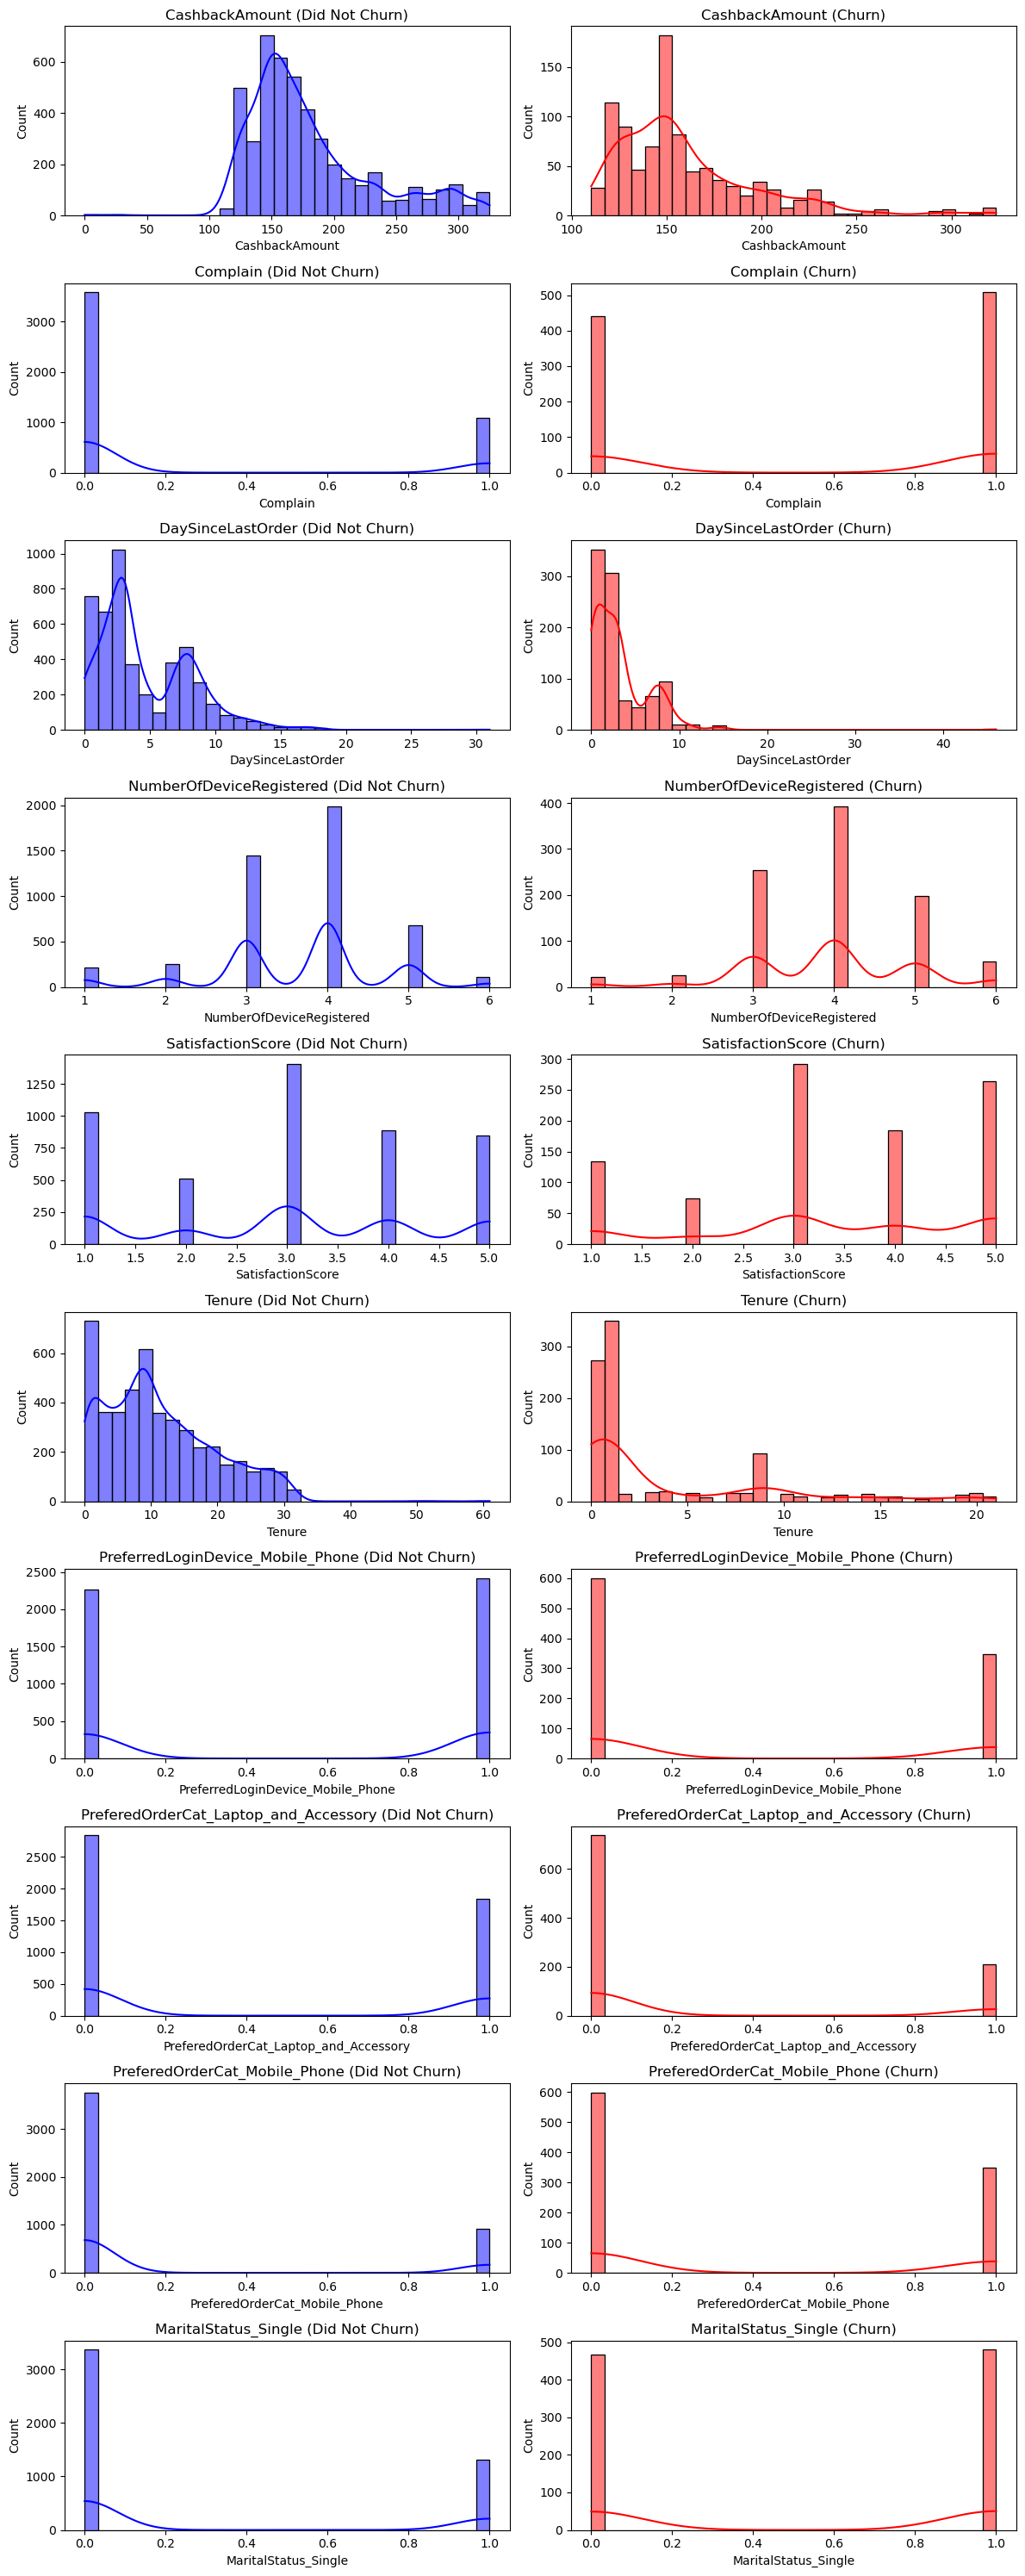

In [50]:
#Lets visualize distributionof each feature for each class label. 
#Distributions that are similar for the two class values will not provide much information to the model

features = [
    'CashbackAmount', 'Complain', 'DaySinceLastOrder', 'NumberOfDeviceRegistered', 
    'SatisfactionScore', 'Tenure', 'PreferredLoginDevice_Mobile_Phone', 
    'PreferedOrderCat_Laptop_and_Accessory', 'PreferedOrderCat_Mobile_Phone', 
    'MaritalStatus_Single'
]

# Number of rows and columns for subplots
num_features = len(features)
rows = num_features  # One row per feature
cols = 2  # Two columns: One for each class (churn = 0 and churn = 1)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3)) 

# Loop through features and plot side-by-side histograms
for i, feature in enumerate(features):
    # Plot histogram for Y = 0 (Did Not Churn)
    sns.histplot(
        data=X_dataset[Y_dataset == 0], x=feature, bins=30, kde=True, color="blue", ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'{feature} (Did Not Churn)')
    
    # Plot histogram for Y = 1 (Churn)
    sns.histplot(
        data=X_dataset[Y_dataset == 1], x=feature, bins=30, kde=True, color="red", ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'{feature} (Churn)')

# Adjust layout
plt.tight_layout()
plt.show()



# Comparing distribution of each feature across the two class labels

    Findings:

        Distribution of all features are dissimilar across the two class labels (churn, did not churn) except for one feature (‘NumberOfDeviceRegistered’), indicating that all features except for ‘NumberOfDeviceRegistered’ can contribute information to the model.

        So, we will drop ‘NumberOfDeviceRegistered’

In [51]:
print(X_dataset.shape)
X_dataset.columns

(5630, 10)


Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'Tenure',
       'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

In [52]:
X_dataset = X_dataset.drop(columns=['NumberOfDeviceRegistered'])

In [53]:
print(X_dataset.shape)
X_dataset.columns

(5630, 9)


Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder', 'SatisfactionScore',
       'Tenure', 'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

In [54]:
print("_"*125)
print(" Our master training data set")
print("_"*125)
print(f" Shape of X_dataset : { X_dataset.shape }")
print(f" Shape of Y_dataset : { Y_dataset.shape }")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
 Our master training data set
_____________________________________________________________________________________________________________________________
 Shape of X_dataset : (5630, 9)
 Shape of Y_dataset : (5630,)
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


  # 
    Plot histogram of Churned column to see if class distribution is imbalanced

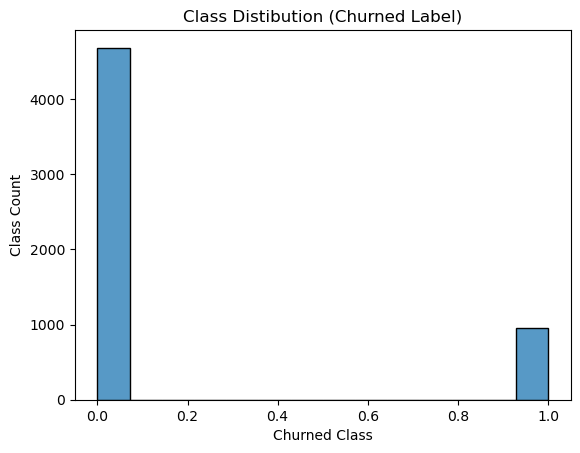

In [55]:
sns.histplot(Y_dataset)
plt.xlabel('Churned Class')
plt.ylabel('Class Count')
plt.title('Class Distibution (Churned Label)')
plt.show()

In [56]:
num_churned, num_not_churned, num_total_customers = np.sum(Y_dataset == 1), np.sum(Y_dataset ==0), len(Y_dataset)
perc_churned = round((num_churned / num_total_customers) * 100, 2)
perc_not_churned = round((num_not_churned / num_total_customers) * 100, 2)
print(f"Churned: {perc_churned}%")
print(f"Not Churned: {perc_not_churned}%")

Churned: 16.84%
Not Churned: 83.16%


# Class Imbalance analysis, findings and approach
    Our class distribution is unbalanced. 83.16% of the customers have not churned. So, a naive model that just predicts ‘will not churn’ will be 83.16% accurate.

    To prevent our models from learning too much from the majority class, we need to mitigate this class imbalance.

    Two strategies are: oversample from minority class by creating synthetic data, or under sample from majority class.

    Latter approach is not preferred since our data set is modest sized, and we may lose information.

    Oversampling may be ok, because our data set is modest, and creating more samples may not reduce the model speed a lot. We will use SMOTE oversampling that will increase samples from minority class to be 40% of total. SMOTE uses nearest neighbors to generate new samples between existing points.



# But to prevent data leakage we will apply SMOTE after splitting and ONLY to training data set and not to validation and test data sets.

    Planned  Workflow
    1. Split data:
        First, split X_train into train, validation, and test (without SMOTE).
    2. Apply SMOTE: Only apply SMOTE on the training set.
    3. Train the model: Use the resampled training set but evaluate on the original validation and test sets.

# POST THIS PREVIOUS TO APR 2 2025

# Towards X_dataset construction
   


# Workflow:
    1) Split the data into train, val, and test (75,15,15).
        Using 75-15-15 split (versus 60-20-20) since our data set is modest and to give enough samples for training and SMOTE
    2) Apply SMOTE to train data set 
        Sampling stratgey of 0.4 brings churners to 40% of the majority class (appx. brings churners from 17% to ~29%, improving balance while still 
        keeping data realistic.)
    3) Std scale (fit) on SMOTEd train data. Use mean and std dev of train data to std scale val, and test data
        - This prevents data leakage from test to train. 

In [57]:
# Train (70%) and Temp (30%) split
X_train_orig, X_temp, Y_train_orig, Y_temp = train_test_split(X_dataset, Y_dataset, test_size=0.3, random_state=42, stratify=Y_dataset)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE on Training Set Only
smote = SMOTE(sampling_strategy=0.4, random_state=42)  
X_train, y_train = smote.fit_resample(X_train_orig, Y_train_orig)



# Note: X_train, Y_train are SMOTE resampled. 

In [58]:
# Post SMOTE class distrubution
num_churned, num_not_churned, num_total_customers = np.sum(y_train == 1), np.sum(y_train ==0), len(y_train)
perc_churned = round((num_churned / num_total_customers) * 100, 2)
perc_not_churned = round((num_not_churned / num_total_customers) * 100, 2)
print(f"Churned: {perc_churned}%")
print(f"Not Churned: {perc_not_churned}%")

Churned: 28.56%
Not Churned: 71.44%


# Post SMOTE our training class distribution is (71-29), more blanced than 83-17 in original data set

In [59]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train) = }, { X_train.shape = }, { type(y_train) = } , { y_train.shape = }")
print(f"{ type(X_val) = }, { X_val.shape = }, { type(y_val) = } , { y_val.shape = }")
print(f"{ type(X_test) = }, { X_test.shape = }, { type(y_test) = } , { y_test.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train) = <class 'pandas.core.frame.DataFrame'>,  X_train.shape = (4587, 9),  type(y_train) = <class 'numpy.ndarray'> ,  y_train.shape = (4587,)
 type(X_val) = <class 'pandas.core.frame.DataFrame'>,  X_val.shape = (844, 9),  type(y_val) = <class 'numpy.ndarray'> ,  y_val.shape = (844,)
 type(X_test) = <class 'pandas.core.frame.DataFrame'>,  X_test.shape = (845, 9),  type(y_test) = <class 'numpy.ndarray'> ,  y_test.shape = (845,)
______________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________

# Scaling.
    1. Now we will standard scale x_train, x_val, and X_test data sets

In [60]:
summarize_dataframe(X_train)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CashbackAmount,float64,0,4587,2876
1,Complain,int64,0,4587,2
2,DaySinceLastOrder,float64,0,4587,301
3,SatisfactionScore,int64,0,4587,5
4,Tenure,float64,0,4587,206
5,PreferredLoginDevice_Mobile_Phone,float64,0,4587,138
6,PreferedOrderCat_Laptop_and_Accessory,float64,0,4587,82
7,PreferedOrderCat_Mobile_Phone,float64,0,4587,45
8,MaritalStatus_Single,float64,0,4587,224


In [61]:
#Standard sclaing of X 
scaler_X = StandardScaler()

scaler_X.fit(X_train)

X_train_std = scaler_X.transform(X_train)
X_val_std = scaler_X.transform(X_val)
X_test_std = scaler_X.transform(X_test)

In [62]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train_std) = }, { X_train_std.shape = }, { type(y_train) = } , { y_train.shape = }")
print(f"{ type(X_val_std) = }, { X_val_std.shape = }, { type(y_val) = } , { y_val.shape = }")
print(f"{ type(X_test_std) = }, { X_test_std.shape = }, { type(y_test) = } , { y_test.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train_std) = <class 'numpy.ndarray'>,  X_train_std.shape = (4587, 9),  type(y_train) = <class 'numpy.ndarray'> ,  y_train.shape = (4587,)
 type(X_val_std) = <class 'numpy.ndarray'>,  X_val_std.shape = (844, 9),  type(y_val) = <class 'numpy.ndarray'> ,  y_val.shape = (844,)
 type(X_test_std) = <class 'numpy.ndarray'>,  X_test_std.shape = (845, 9),  type(y_test) = <class 'numpy.ndarray'> ,  y_test.shape = (845,)
______________________________________________________________________________________________________________________________________________________
___________________________________________________________________________________________________

# ________________________SECTION FOR MODEL RUN_______________